# Task:-> Hospitality Employees Prediction.
## Dataset:-> Data  from year 1990 to 2018.
## Model:-> 

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("./Data/HospitalityEmployees.csv",index_col='Date',parse_dates=True)

In [3]:
df.head()

,Employees
Date,
1990-01-01,1064.5
1990-02-01,1074.5
1990-03-01,1090.0
1990-04-01,1097.4
1990-05-01,1108.7


In [4]:
df.plot(figsize=(12,5));

In [5]:
df.describe()

,Employees
count,348.000000
mean,1452.506897
std,256.604914
min,1064.500000
25%,1238.050000
50%,1436.200000
75%,1586.300000
max,2022.100000


In [6]:
df.index.freq = 'MS'

In [7]:
df.index

DatetimeIndex(['1990-01-01', '1990-02-01', '1990-03-01', '1990-04-01',
               '1990-05-01', '1990-06-01', '1990-07-01', '1990-08-01',
               '1990-09-01', '1990-10-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', name='Date', length=348, freq='MS')

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['Employees'],model='mul');

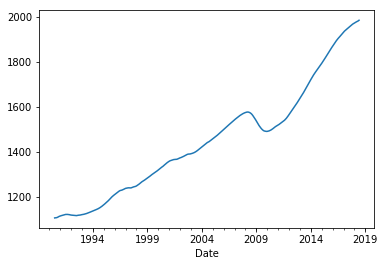

In [9]:
results.trend.plot();

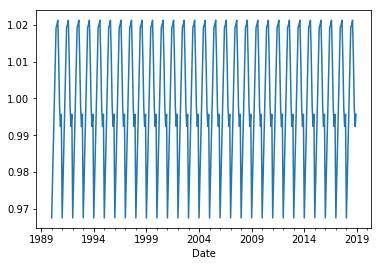

In [10]:
results.seasonal.plot();

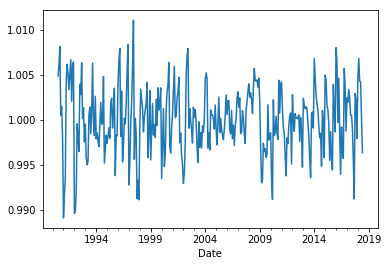

In [11]:
results.resid.plot();

# ADF Test
Let's Check the Staionarity of our data!

In [12]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series,autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [13]:
adf_test(df)

Augmented Dickey-Fuller Test: 
ADF test statistic        0.901284
p-value                   0.993107
# lags used              17.000000
# observations          330.000000
critical value (1%)      -3.450322
critical value (5%)      -2.870338
critical value (10%)     -2.571458
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


Here we can see that p>0.05 so,
can't reject the null hypothesis. And also
data has a unit root and is non-stationary.

# Let's apply differencing 

In [14]:
# create a differenced df

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff


In [15]:
# Let take first difference of the data

df_first_diff = difference(df['Employees'])


In [16]:
# Make Data frame 

In [17]:
# Let's again do  adf test

adf_test(df_first_diff)

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.068279
p-value                   0.028992
# lags used              17.000000
# observations          329.000000
critical value (1%)      -3.450384
critical value (5%)      -2.870365
critical value (10%)     -2.571472
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


 # BOXCOS TRANSFORM
<ul>
    <li> lambda = -1. is a reciprocal transform.</li>
    <li>lambda = -0.5 is a reciprocal square root transform.</li>
    <li>lambda = 0.0 is a log transform. </li>
    <li>lambda = 0.5 is a square root transform. </li>
    <li>lambda = 1.0 is no transform. </li>
</ul>

In [18]:
# from scipy.stats import boxcox
# from matplotlib import pyplot
# dataframe = pd.DataFrame(df.values)
# dataframe.columns = ['Employees']
# dataframe['Employees'], lam = boxcox(dataframe['Employees'])
# print('Lambda: %f' % lam)
# pyplot.figure(1)
# # line plot
# pyplot.subplot(211)
# pyplot.plot(dataframe['Employees'])
# # histogram
# pyplot.subplot(212)
# pyplot.hist(dataframe['Employees'])
# pyplot.show()

# ACF and PACF Plot for p,d,q values

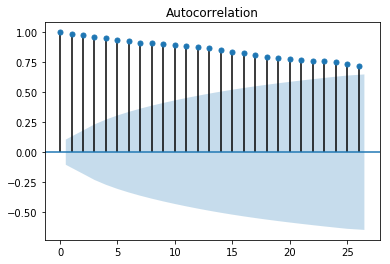

In [19]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df['Employees']);

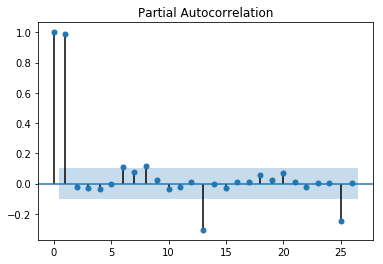

In [20]:
plot_pacf(df['Employees']);

In [21]:
# df

In [22]:
idx = pd.date_range('1990-02-01','2018-12-01', freq='MS')
df_first_diff = pd.DataFrame(df_first_diff, index=idx, columns=['Emp_1d'])
df_first_diff.head()

,Emp_1d
1990-02-01,10.0
1990-03-01,15.5
1990-04-01,7.4
1990-05-01,11.3
1990-06-01,14.8


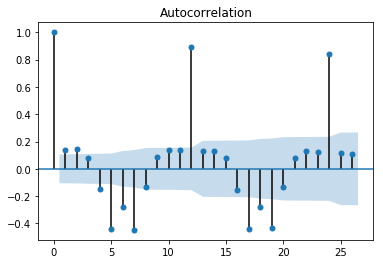

In [23]:
plot_acf(df_first_diff['Emp_1d']);

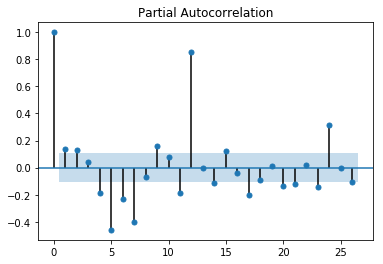

In [24]:
plot_pacf(df_first_diff['Emp_1d']);

In [25]:
nobs = 12
train, test = df_first_diff['Emp_1d'][:-nobs], df_first_diff['Emp_1d'][-nobs:]

In [26]:
train.head()

1990-02-01    10.0
1990-03-01    15.5
1990-04-01     7.4
1990-05-01    11.3
1990-06-01    14.8
Freq: MS, Name: Emp_1d, dtype: float64

In [27]:
test.head()

2018-01-01   -40.4
2018-02-01    27.7
2018-03-01    17.7
2018-04-01    22.7
2018-05-01    16.6
Freq: MS, Name: Emp_1d, dtype: float64

In [28]:
from pmdarima import auto_arima
auto_arima(df['Employees'],seasonal=False).summary()

C:\Users\kishan\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kishan\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\kishan\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kishan\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  348
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1360.484
Date:                Thu, 20 Feb 2020   AIC                           2734.969
Time:                        23:25:36   BIC                           2761.914
Sample:                             0   HQIC                          2745.697
                                - 348                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7014      0.131      5.337      0.000       0.444       0.959
ar.L1          1.7316      0.001   1329.158      0.000       1.729       1.734
ar.L2         -0.9998      0.001  -1777.587      0.000      -1.001      -0.999
ma.L1         -2.1871      0.043    -50.402      0.000      -2.272      -2.102
ma.L2          1.8041      0.075     23.980      0.000       1.657       1.952
ma.L3         -0.4704      0.043    -10.934      0.000      -0.555      -0.386
sigma2       145.6796     10.765     13.533      0.000     124.580     166.779
===================================================================================
Ljung-Box (Q):                      778.33   Jarque-Bera (JB):                65.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.77
Prob(H) (two-sided):                  0.25   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
import warnings
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

model = ARIMA(train, order=(2,1,3))
model_fit =  model.fit(trend='nc', disp=0)

C:\Users\kishan\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [30]:
start=len(train)
end=len(train)+len(test)-1
first_predictions = model_fit.predict(start=start, end=end, dynamic=False, typ='levels')

In [31]:
first_predictions

2018-01-01   -4.248242
2018-02-01    6.855977
2018-03-01   -2.601638
2018-04-01    7.516900
2018-05-01   -2.336344
2018-06-01    7.623379
2018-07-01   -2.293598
2018-08-01    7.640530
2018-09-01   -2.286707
2018-10-01    7.643289
2018-11-01   -2.285593
2018-12-01    7.643730
Freq: MS, dtype: float64

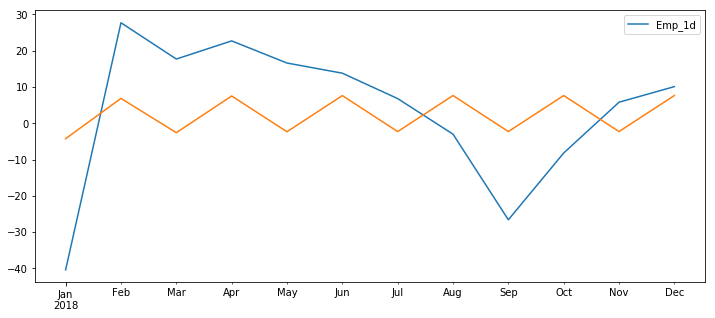

In [32]:
test.plot(figsize=(12,5),legend=True);
first_predictions.plot();

In [33]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test, first_predictions)
print(f'ARIMA(2,1,3) RMSE Error: {error:11.10}')

ARIMA(2,1,3) RMSE Error: 18.00535155


In [34]:
test.mean()

3.5833333333333335

# StepWise Fiting of data

In [35]:
import warnings
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # difference data
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                        print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# load dataset
#series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=19.545
ARIMA(0, 0, 2) RMSE=19.433
ARIMA(0, 1, 2) RMSE=19.314
ARIMA(0, 1, 3) RMSE=19.220
ARIMA(1, 0, 4) RMSE=18.698
ARIMA(1, 1, 3) RMSE=17.576
ARIMA(2, 1, 2) RMSE=17.238
ARIMA(4, 0, 2) RMSE=16.658
ARIMA(4, 0, 4) RMSE=15.799
Best ARIMA(4, 0, 4) RMSE=15.799


In [47]:
model = ARIMA(train, order=(4,0,4))
model_fit =  model.fit(trend='nc', disp=0)

In [48]:
start=len(train)
end=len(train)+len(test)-1
sec_predictions = model_fit.predict(start=start, end=end, dynamic=False, typ='levels')

In [49]:
sec_predictions

2018-01-01    -9.516999
2018-02-01     8.759876
2018-03-01     9.124954
2018-04-01    11.208395
2018-05-01    21.641787
2018-06-01    10.712034
2018-07-01     1.265752
2018-08-01     2.643458
2018-09-01   -12.261231
2018-10-01   -19.348445
2018-11-01   -10.283413
2018-12-01   -14.041566
Freq: MS, dtype: float64

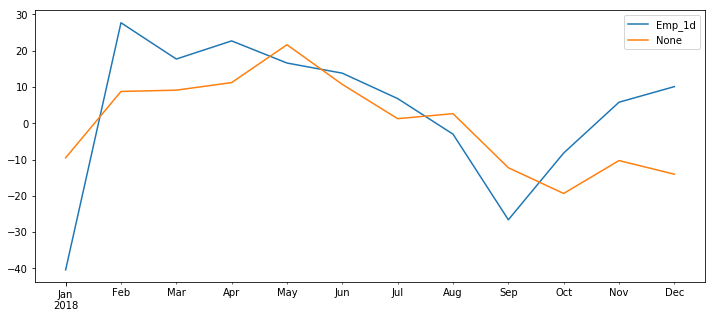

In [50]:
test.plot(figsize=(12,5),legend=True);
sec_predictions.plot(legend=True);

In [51]:
error = rmse(test, sec_predictions)
print(f'ARIMA(4,0,4) RMSE Error: {error:11.10}')

ARIMA(4,0,4) RMSE Error: 15.23944333


# SARIMAX MODEL

In [94]:
auto_arima(df['Employees'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  348
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1098.306
Date:                              Fri, 21 Feb 2020   AIC                           2210.612
Time:                                      00:35:12   BIC                           2237.558
Sample:                                           0   HQIC                          2221.341
                                              - 348                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.005      0.081      0.935      -0.010       0.011
ar.L1          0.9225      0.046     20.245      0.000       0.833       1.012
ma.L1         -0.9439      0.070    -13.421      0.000      -1.082      -0.806
ma.L2          0.1317      0.060      2.192      0.028       0.014       0.249
ar.S.L12       0.9977      0.001    717.676      0.000       0.995       1.000
ma.S.L12      -0.7569      0.042    -17.884      0.000      -0.840      -0.674
sigma2        29.1930      1.701     17.161      0.000      25.859      32.527
===================================================================================
Ljung-Box (Q):                       32.10   Jarque-Bera (JB):                66.50
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.09
Prob(H) (two-sided):                  0.45   Kurtosis:                         5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [95]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train ,order=(1,1,2),seasonal_order=(1, 0, 1, 12))

In [96]:
results = model.fit()

In [97]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               Emp_1d   No. Observations:                  335
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1071.002
Date:                              Fri, 21 Feb 2020   AIC                           2154.004
Time:                                      00:37:55   BIC                           2176.871
Sample:                                  02-01-1990   HQIC                          2163.122
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9662      0.142     -6.793      0.000      -1.245      -0.687
ma.L1         -0.0326      0.073     -0.448      0.654      -0.175       0.110
ma.L2         -0.9666      0.210     -4.609      0.000      -1.378      -0.556
ar.S.L12       0.9944      0.003    386.059      0.000       0.989       0.999
ma.S.L12      -0.7023      0.054    -12.966      0.000      -0.808      -0.596
sigma2        32.2360      2.793     11.541      0.000      26.761      37.711
===================================================================================
Ljung-Box (Q):                       95.72   Jarque-Bera (JB):                49.13
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -0.42
Prob(H) (two-sided):                  0.44   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [98]:
start = len(train)
end   = len(train)+len(test)-1
third_predictions = results.predict(start,end,typ ='level')

In [99]:
third_predictions

2018-01-01   -33.810982
2018-02-01    21.299246
2018-03-01    19.486786
2018-04-01    24.797410
2018-05-01    20.739604
2018-06-01    17.497465
2018-07-01     7.972724
2018-08-01     2.473089
2018-09-01   -17.993886
2018-10-01    -3.319375
2018-11-01    -7.461183
2018-12-01     3.944933
Freq: MS, dtype: float64

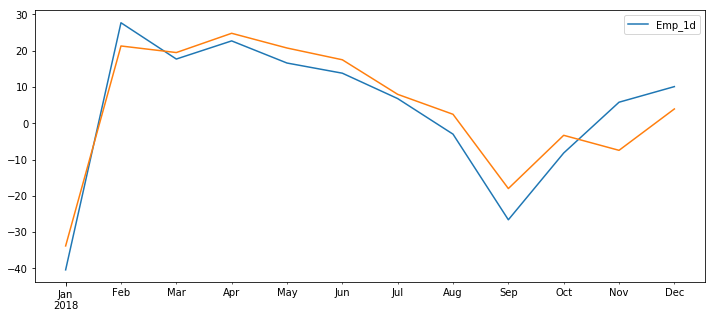

In [100]:
test.plot(figsize=(12,5),legend=True)
third_predictions.plot(figsize=(12,5));

In [101]:
error = rmse(test, third_predictions)
print(f'SARIMA(2,0,2) RMSE Error: {error:11.10}')

SARIMA(2,0,2) RMSE Error: 6.229925182


In [102]:
test.mean()

3.5833333333333335

In [103]:
idx = pd.date_range('01/01/2018', periods=12, freq='MS')
df_forecast = pd.DataFrame(third_predictions, index=idx, columns=['third_pred'])
df_forecast

,third_pred
2018-01-01,-33.810982
2018-02-01,21.299246
2018-03-01,19.486786
2018-04-01,24.797410
2018-05-01,20.739604
2018-06-01,17.497465
2018-07-01,7.972724
2018-08-01,2.473089
2018-09-01,-17.993886
2018-10-01,-3.319375


In [104]:
def inverse_difference(history, yhat, interval=-13):
    yhat['Employees_org']= history['Employees'].iloc[interval] + yhat['third_pred'].cumsum()
    return yhat

In [105]:
test_org = inverse_difference(df,df_forecast)

In [106]:
test_org

,third_pred,Employees_org
2018-01-01,-33.810982,1923.389018
2018-02-01,21.299246,1944.688263
2018-03-01,19.486786,1964.175049
2018-04-01,24.797410,1988.972459
2018-05-01,20.739604,2009.712063
2018-06-01,17.497465,2027.209528
2018-07-01,7.972724,2035.182252
2018-08-01,2.473089,2037.655341
2018-09-01,-17.993886,2019.661455
2018-10-01,-3.319375,2016.342080


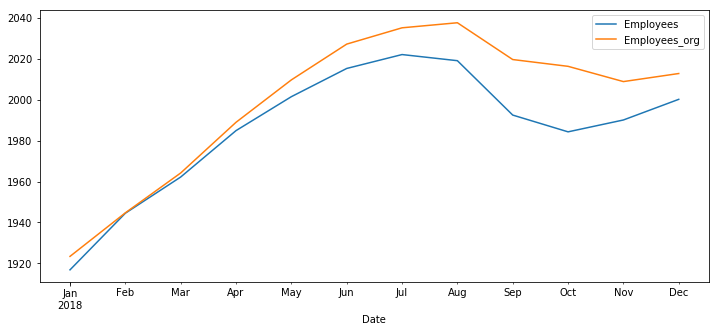

In [107]:
df[-12:].plot(figsize=(12,5))
df_forecast['Employees_org'].plot(figsize=(12,5),legend=True)

In [108]:
df_forecast['test_org'] = df[-13:]

In [109]:
df_forecast

,third_pred,Employees_org,test_org
2018-01-01,-33.810982,1923.389018,1916.8
2018-02-01,21.299246,1944.688263,1944.5
2018-03-01,19.486786,1964.175049,1962.2
2018-04-01,24.797410,1988.972459,1984.9
2018-05-01,20.739604,2009.712063,2001.5
2018-06-01,17.497465,2027.209528,2015.3
2018-07-01,7.972724,2035.182252,2022.1
2018-08-01,2.473089,2037.655341,2019.1
2018-09-01,-17.993886,2019.661455,1992.5
2018-10-01,-3.319375,2016.342080,1984.3


In [92]:
error = rmse(df_forecast['test_org'], df_forecast['Employees_org'])
print(f'SARIMAX(2,0,2) RMSE Error: {error:11.10}')

SARIMAX(2,0,2) RMSE Error: 8.440533999


In [93]:
df_forecast['test_org'].mean()

1986.125